### Meta

In [108]:
# Autoreload modules without having to restart the notebook kernel.
%load_ext autoreload
%autoreload 2


# Plotting code stolen from Georg's notebook.
import matplotlib.pyplot as plt

%matplotlib inline
font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 32}
plt.rc('font', **font)

import sys

sys.path.insert(1, "..\\")

#import markov_clustering as mcl
import pandas as pd
import seaborn as sns

# Personal libraries
import lib.files
import lib.graph
import lib.constants
import lib.centrality
import lib.cluster

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


I begin by reading in the network and a dataframe I have constructed with the following columns:
- protein:: systematic name
- deg: degree
- global_bet_cent:: betweeness centrality in the entire network
- global_eig_cent:: eigenvector centrality in the entire network
- global_deg_cent:: degree centrality in the entire network
- global_bridge_cent:: bridging centrality in the entire network
- icp55_shortest_path:: shortest path from icp55
- pim1_shortest_path:: shortest path from pim1
- inv:: 1 if inviable, 0 if not
- cluster:: the id of the mcl cluster it belongs to
- cluster_size:: the size of the mcl cluster it belongs to
- mcl_bet_cent:: betweeness centrality within the mcl cluster
- mcl_eig_cent:: eigenvector centrality within the mcl cluster
- mcl_deg_cent:: degree centrality within the mcl cluster

In [135]:
network = lib.graph.read_weighted_edgelist(lib.files.make_filepath_to_networks('icp55-cc-900-inv.txt'))
df = pd.read_csv(lib.files.path_to_tables('icp55-cc-900-inv.csv'), index_col=0, header=0)
df.head()

,protein,deg,global_bet_cent,global_eig_cent,global_bridge_cent,icp55_shortest_path,pim1_shortest_path,inv,cluster,mcl_bet_cent,mcl_deg_cent,mcl_eig_cent,cluster_size
0,4932.Q0010,6,0.001093,1.901319e-08,0.000072,6,6,0,126,0.119048,0.857143,0.416800,8
1,4932.Q0017,5,0.000000,2.365411e-10,0.000000,7,7,0,126,0.000000,0.714286,0.390633,8
2,4932.Q0143,6,0.001093,1.901319e-08,0.000072,6,6,0,126,0.119048,0.857143,0.416800,8
3,4932.Q0092,3,0.003059,3.093142e-06,0.001277,5,5,0,126,0.000000,0.285714,0.161351,8
4,4932.Q0182,5,0.000000,2.365411e-10,0.000000,7,7,0,126,0.000000,0.714286,0.390633,8


I then perform exploratory data analysis using the seaborn pairplot function.

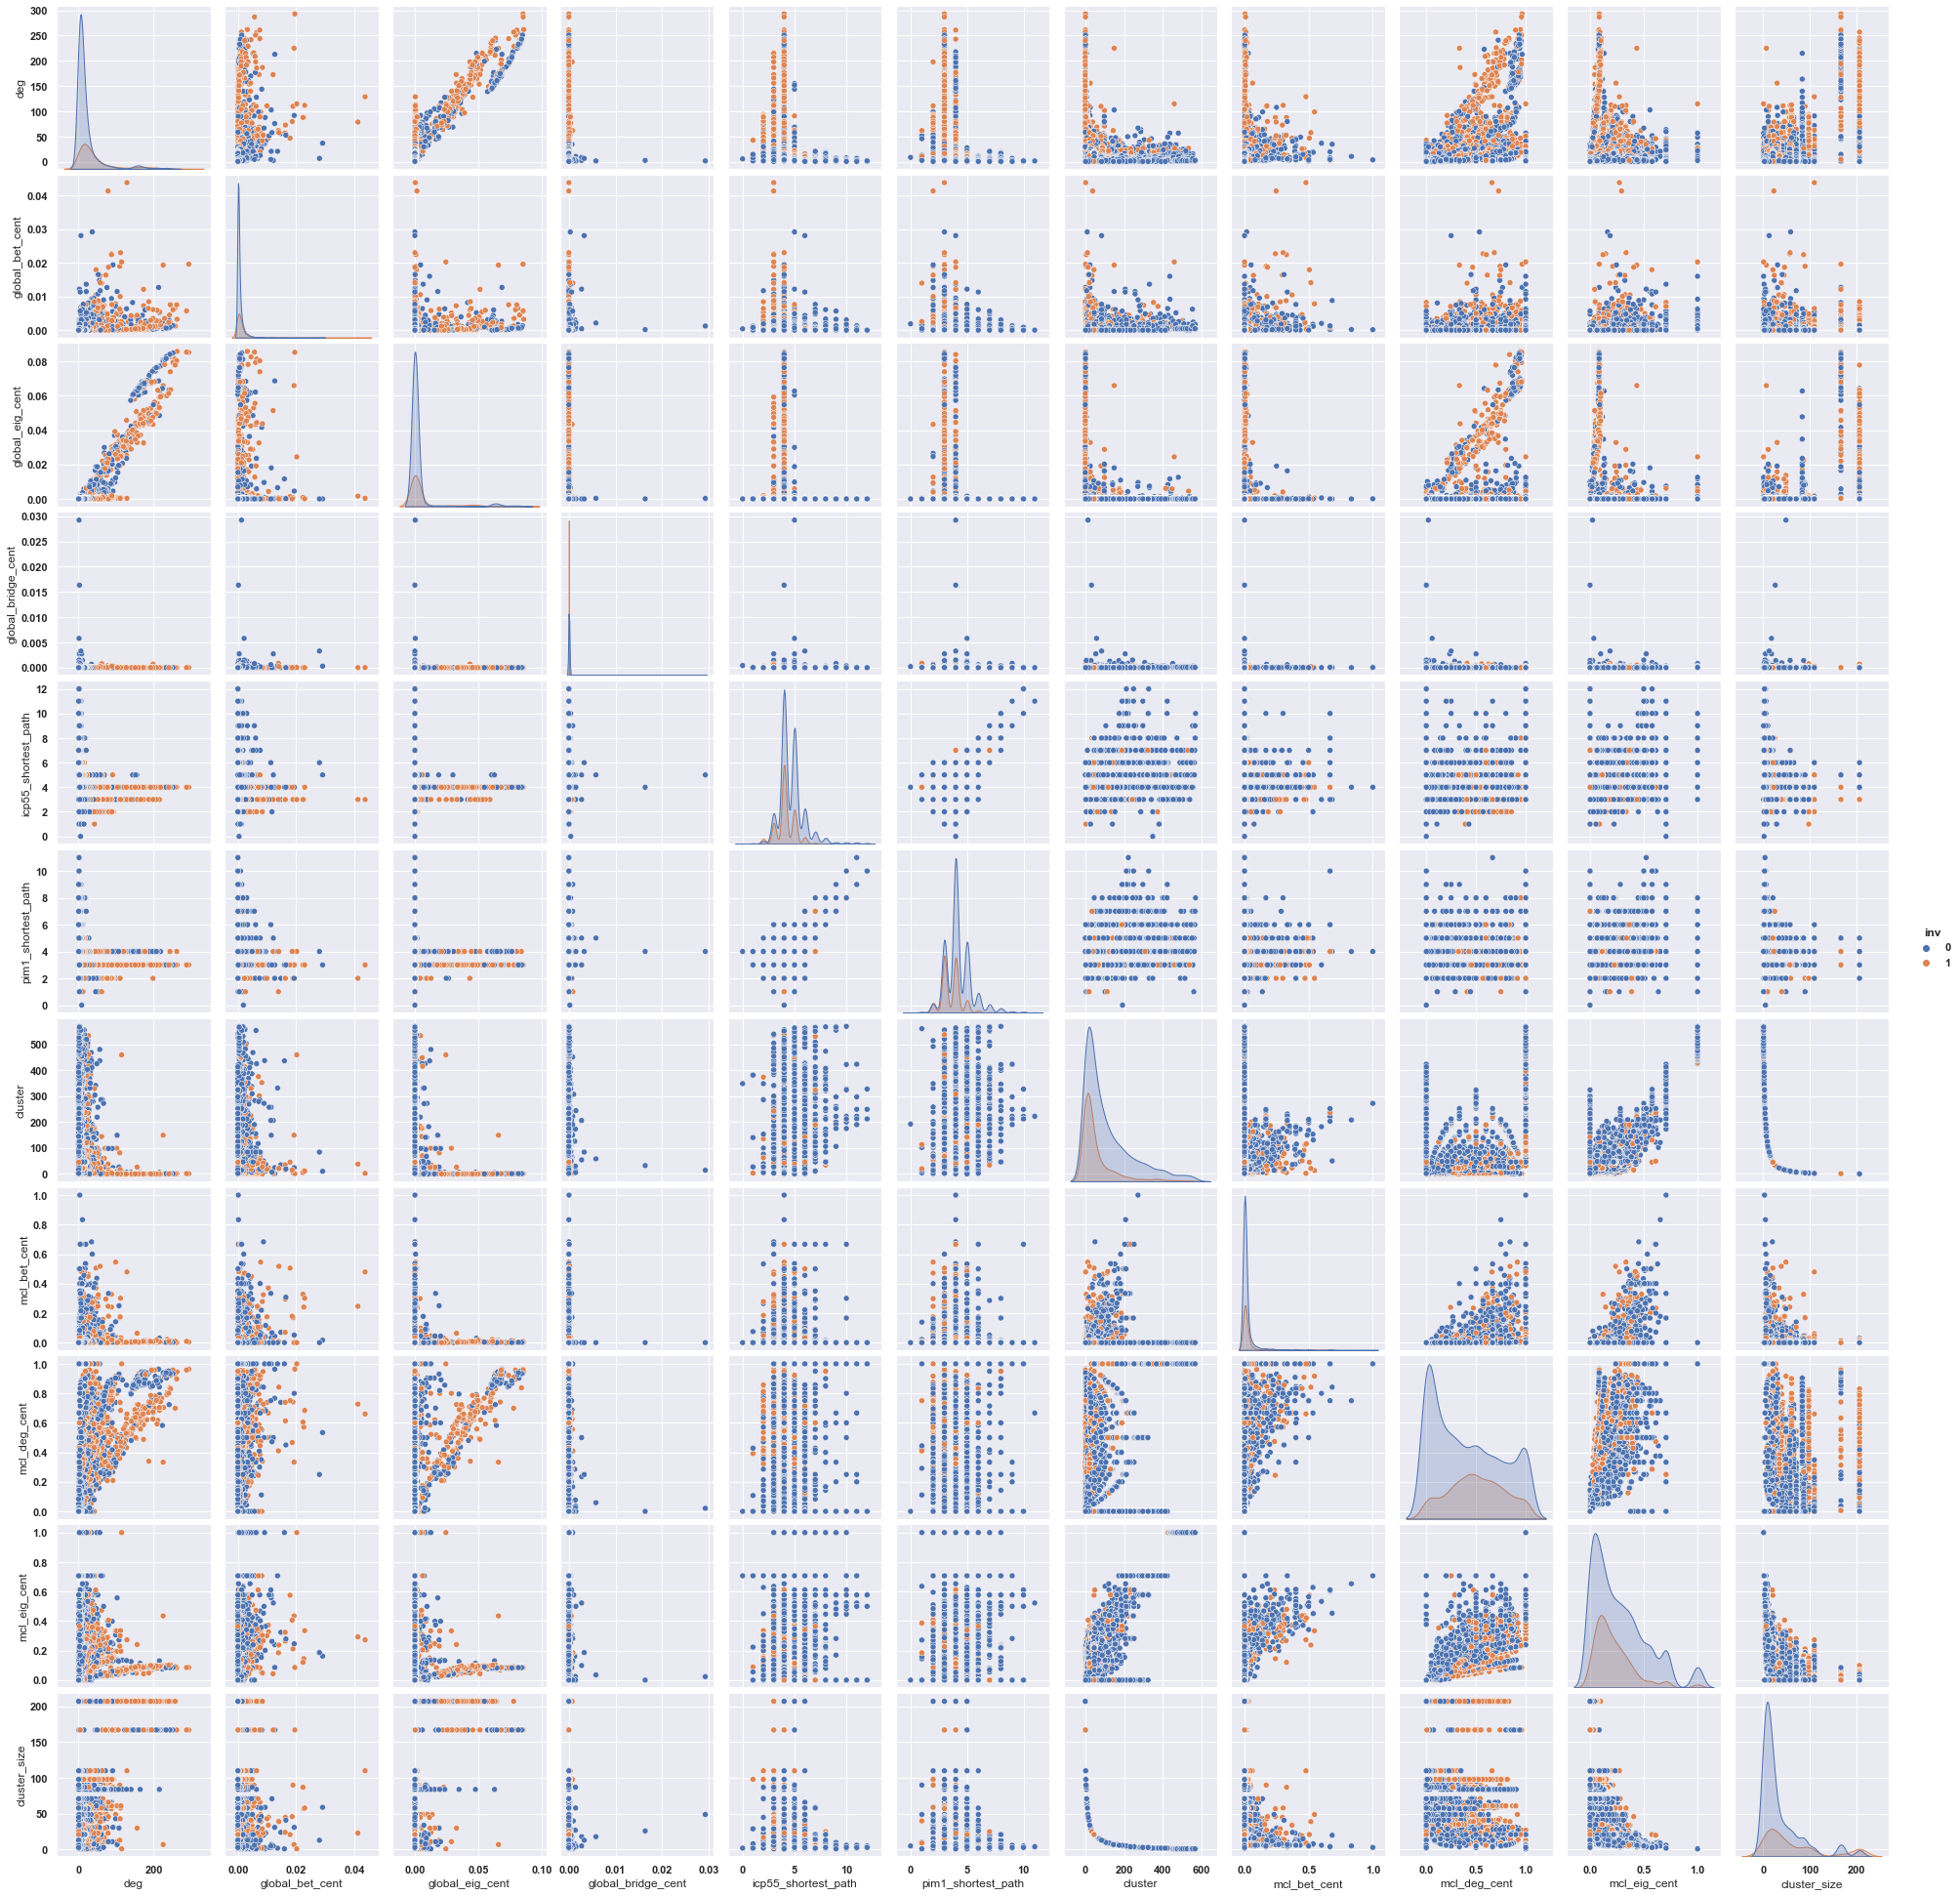

In [136]:
sns.set()
sns.pairplot(df,
             diag_kind='kde',
             hue='inv')

I reduce the variables to reduce clutter and colour the proteins by inviability. Notice in icp55_shortest_path x global_bet_cent there are two non-inviable proteins that stand out. Also bridging_centrality seems to have 2 outlier nodes.

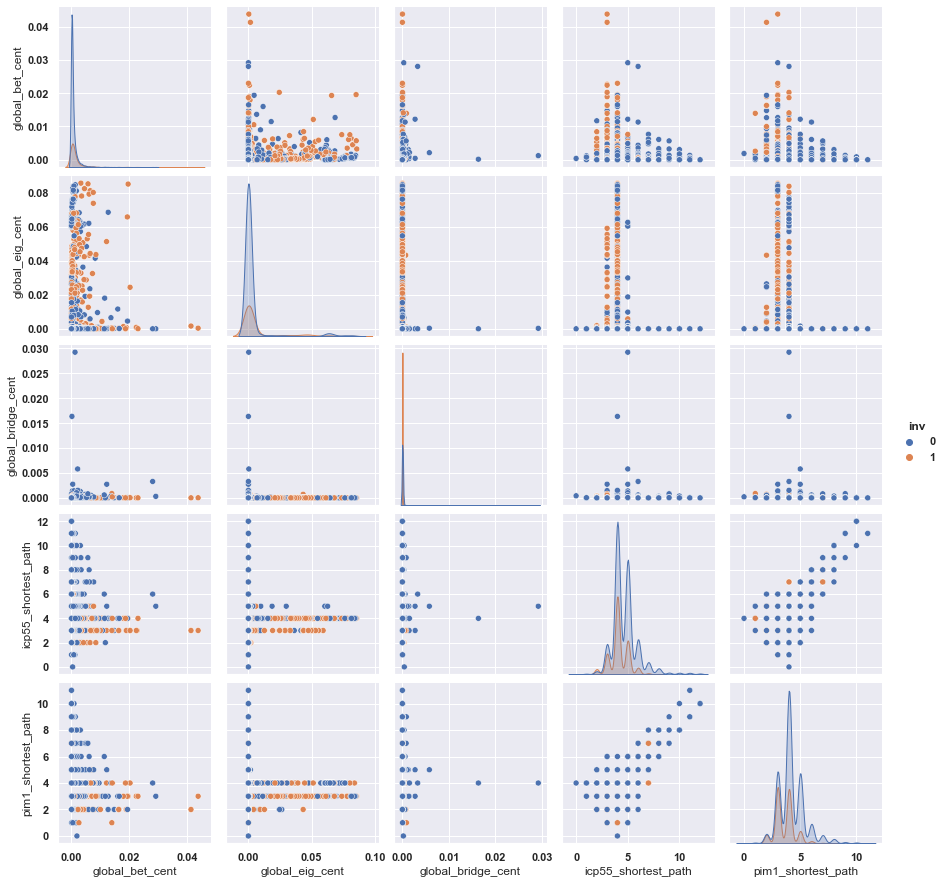

In [137]:
sns.set()
sns.pairplot(df,
             vars=['global_bet_cent', 'global_eig_cent', 'global_bridge_cent', 'icp55_shortest_path', 'pim1_shortest_path'],
             diag_kind='kde',
             hue='inv'
             )

To find these proteins I query the dataframe. Let's pass these to the biology students! If you query the protein name without the 4932 in STRING (and changing the settings to confidence score > 900 + 20 1st shell interactors and 20 2nd shell interactors to show) you'll see that bridging centrality really does seem to bridge clusters. The fifth node 4932.YJL225C seems to connect one potential cluster to another almost definite cluster. I would consider this a target protein for something.

In [147]:
# These proteins have high betweeness centrality and are not inviable.
df1 = df[(df['global_bet_cent'] >= 0.02) & (df['inv'] == 0)]
df1.head()

,protein,deg,global_bet_cent,global_eig_cent,global_bridge_cent,icp55_shortest_path,pim1_shortest_path,inv,cluster,mcl_bet_cent,mcl_deg_cent,mcl_eig_cent,cluster_size
317,4932.Q0120,37,0.029130,1.448779e-05,0.000302,5,3,0,10,0.016591,0.534483,0.162923,59
1730,4932.YJL225C,7,0.028042,8.852234e-08,0.003288,6,4,0,84,0.000000,0.250000,0.186511,13


In [143]:
# These proteins have high bridgeing centrality and are not inviable.
df2 = df[(df['global_bridge_cent'] >= 0.01) & (df['inv'] == 0)]
df2.head()

,protein,deg,global_bet_cent,global_eig_cent,global_bridge_cent,icp55_shortest_path,pim1_shortest_path,inv,cluster,mcl_bet_cent,mcl_deg_cent,mcl_eig_cent,cluster_size
4097,4932.YGL181W,3,0.000160,0.000005,0.016347,4,4,0,32,0.0,0.000000,1.525555e-14,26
4438,4932.YGR149W,2,0.001227,0.000277,0.029228,5,4,0,14,0.0,0.020833,2.349291e-02,49


In [145]:
# This protein has a high betweeness centrality and a moderate bridging centrality and is not inviable.
df3 = df[(df['global_bridge_cent'] >= 0.0025) & (df['global_bet_cent'] >= 0.02) & (df['inv'] == 0)]
df3.head()

,protein,deg,global_bet_cent,global_eig_cent,global_bridge_cent,icp55_shortest_path,pim1_shortest_path,inv,cluster,mcl_bet_cent,mcl_deg_cent,mcl_eig_cent,cluster_size
1730,4932.YJL225C,7,0.028042,8.852234e-08,0.003288,6,4,0,84,0.0,0.25,0.186511,13


I'm also suspicious of using centrality measures on small clusters. It appears that eigenvector centrality and betweeness centrality decay as a function of cluster size.
Therefore, clustering scores may not be comparable across clusters.

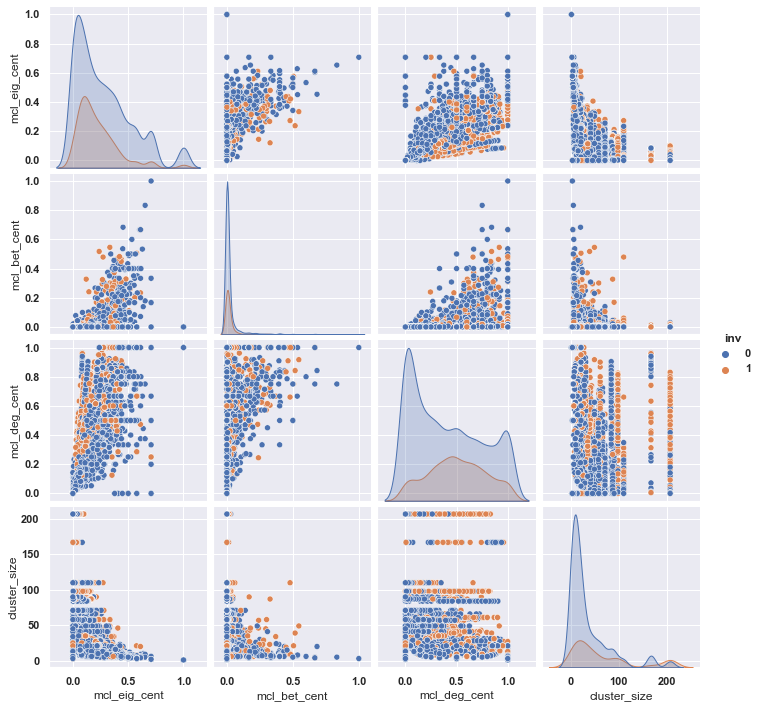

In [140]:
df2 = df[['protein', 'mcl_eig_cent', 'mcl_bet_cent', 'mcl_deg_cent', 'cluster_size', 'inv']]
sns.set()
sns.pairplot(df2,
             diag_kind='kde',
             hue='inv'
             )
